In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# - Design a function to create a 2D Gaussian blob: def gaussian(x, y, x0, y0, sigma): where (x0, y0) represents the center of the Gaussian and sigma the standard deviation.
def gaussian(x, y, x0, y0, sigma):
    return np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))

In [2]:
# Create a coordinate grid for the image, with x and y values ranging from -10 to 10.
x, y = np.linspace(-10, 10, 100), np.linspace(-10, 10, 100)
x, y = np.meshgrid(x, y)

In [3]:

blob1 = 5*gaussian(x, y, x0=-4, y0=-4, sigma=1.2)
blob2 = 10*gaussian(x, y, x0=4, y0=-4, sigma=1.6)
blob3 = 8*gaussian(x, y, x0=0, y0=4, sigma=2.2)

combined_blobs = blob1 + blob2 + blob3

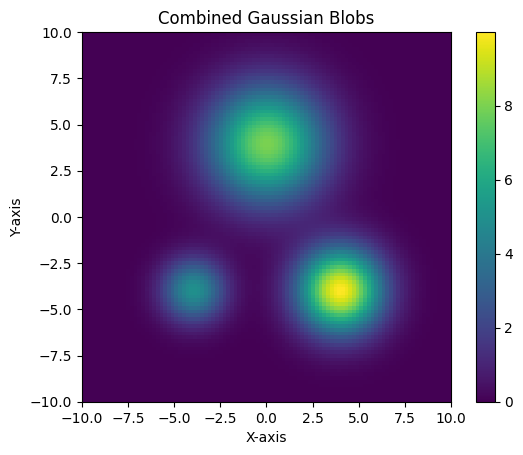

In [4]:
plt.imshow(combined_blobs, extent=(-10, 10, -10, 10), origin='lower', cmap='viridis')
plt.colorbar()
plt.title('Combined Gaussian Blobs')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

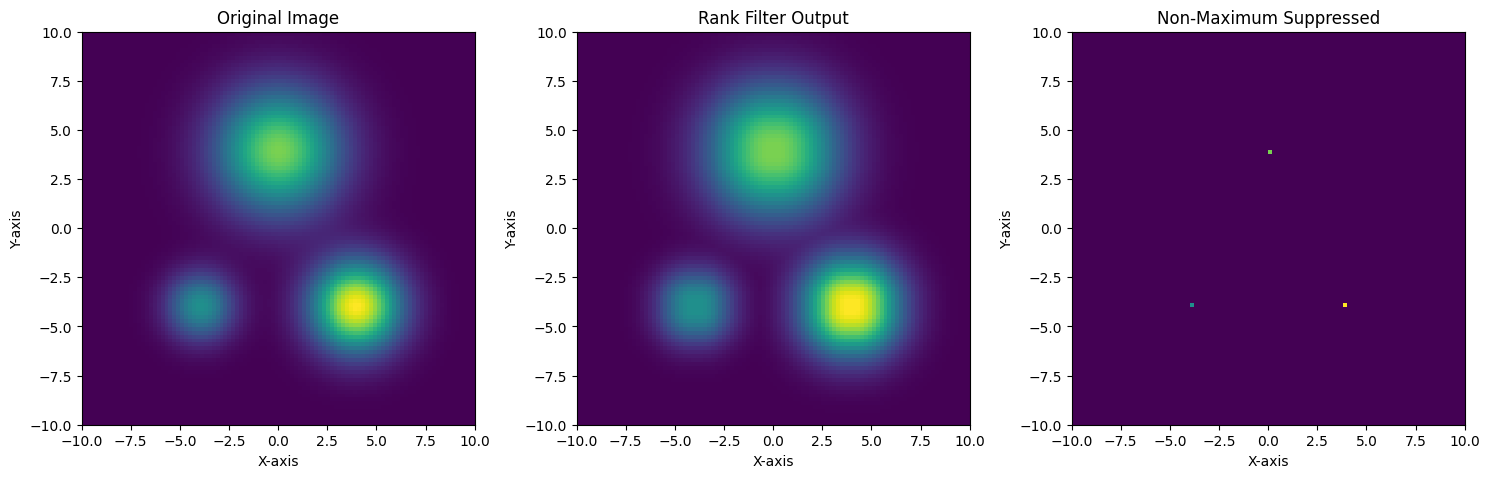

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rank_filter

# Apply rank_filter to the image
max_filter_output = rank_filter(combined_blobs, rank=-1, size=3)

# Combine the original image with the output from rank_filter to retain only the local maxima
non_max_suppressed = np.where(combined_blobs == max_filter_output, combined_blobs, 0)

# Display the original image, the rank_filter output, and the final result
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(combined_blobs, extent=(-10, 10, -10, 10), origin='lower', cmap='viridis')
axes[0].set_title('Original Image')
axes[0].set_xlabel('X-axis')
axes[0].set_ylabel('Y-axis')

axes[1].imshow(max_filter_output, extent=(-10, 10, -10, 10), origin='lower', cmap='viridis')
axes[1].set_title('Rank Filter Output')
axes[1].set_xlabel('X-axis')
axes[1].set_ylabel('Y-axis')

axes[2].imshow(non_max_suppressed, extent=(-10, 10, -10, 10), origin='lower', cmap='viridis')
axes[2].set_title('Non-Maximum Suppressed')
axes[2].set_xlabel('X-axis')
axes[2].set_ylabel('Y-axis')

plt.tight_layout()
plt.show()

## Exercise 1

In [6]:
from scipy.ndimage import gaussian_laplace
import skimage
from skimage import io
x = io.imread('./sunflowers.jpg', as_gray=True)

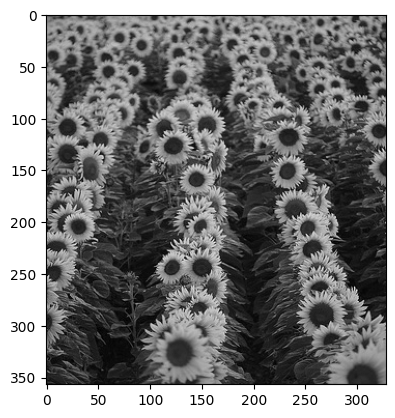

In [7]:
plt.imshow(x, cmap='gray')
plt.show()

In [8]:
sigma = 4
filtered_image = gaussian_laplace(x, sigma=sigma)

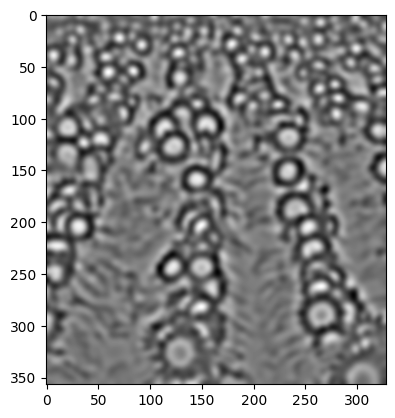

In [9]:
plt.imshow(filtered_image, cmap='gray')
plt.show()

In [10]:
# Apply thresholding to the filtered image
threshold = np.quantile(filtered_image, 0.99)
thresholded = np.where(filtered_image > threshold, filtered_image, 0)

# Perform non-maximum suppression
max_filter_output = rank_filter(thresholded, rank=-1, size=3)
non_max_suppressed = np.where(thresholded == max_filter_output, thresholded, 0)

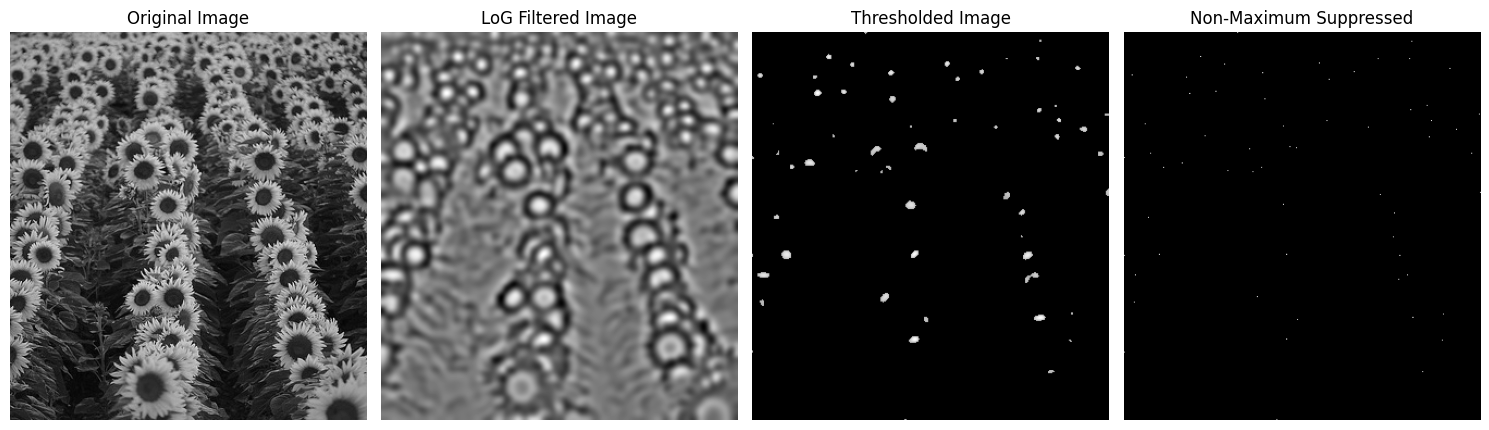

In [11]:
# Display the original image, the LoG filtered image, and the final result
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

axes[0].imshow(x, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(filtered_image, cmap='gray')
axes[1].set_title('LoG Filtered Image')
axes[1].axis('off')

axes[2].imshow(thresholded, cmap='gray')
axes[2].set_title('Thresholded Image')
axes[2].axis('off')

axes[3].imshow(non_max_suppressed, cmap='gray')
axes[3].set_title('Non-Maximum Suppressed')
axes[3].axis('off')

plt.tight_layout()
plt.show()

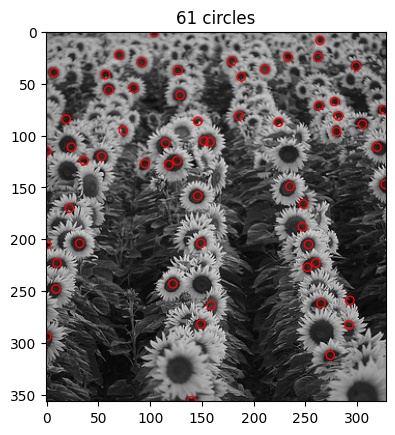

In [12]:
import show_all_circles
# Extract the coordinates of the centers and the radii of the detected blobs
cy, cx = np.nonzero(non_max_suppressed)
rad = np.full_like(cx, sigma)  # Assuming radius is proportional to the variance

show_all_circles.show_all_circles(x, cx, cy, rad)

## Exercise 2

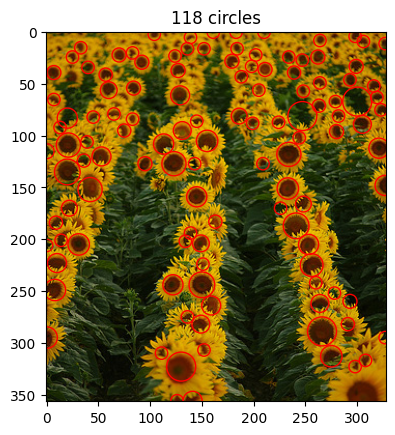

Execution time for filter width approach: 0.2098 seconds


In [13]:
sigma0 = 3
sigmaN = 7
def generate_sigma_space(sigma_0, sigma_max, num_steps):
    # Calculate scale factor 's' based on the geometric progression formula
    s = (sigma_max / sigma_0) ** (1 / (num_steps - 1))
    
    # Generate sigma values using the formula sigma = sigma_0 * s^k
    k_values = np.arange(0, num_steps)
    scales = sigma_0 * s ** k_values
    
    return scales

scales = generate_sigma_space(sigma0, sigma_max=sigmaN, num_steps=15)

scale_space = np.zeros((x.shape[0], x.shape[1], len(scales)))


# Measure execution time for downsampling approach
start_time = time.time()

for i, sigma in enumerate(scales):
    log_filtered = gaussian_laplace(x, sigma=sigma)
    scale_space[:, :, i] = sigma**2 * log_filtered

# Perform non-maximum suppression at each scale
non_max_suppressed_2d = np.zeros_like(scale_space)
for i in range(len(scales)):
    # Apply thresholding to the filtered image
    threshold = np.quantile(scale_space[:, :, i], 0.99)
    thresholded = np.where(scale_space[:, :, i] > threshold, scale_space[:, :, i], 0)
    # Perform non-maximum suppression
    max_filter_output = rank_filter(thresholded, rank=-1, size=5)
    non_max_suppressed_2d[:, :, i] = np.where(thresholded == max_filter_output, thresholded, 0)

# Extend non-maximum suppression to 3D scale-space
max_filter_output_3d = rank_filter(non_max_suppressed_2d, rank=-1, size=(15, 15, len(scales)))
non_max_suppressed = np.where(non_max_suppressed_2d == max_filter_output_3d, non_max_suppressed_2d, 0)

# Measure execution time for downsampling approach
filter_time = time.time() - start_time

# Extract the coordinates of the centers and the radii of the detected blobs
cy, cx, cz = np.nonzero(non_max_suppressed)
radii = [scales[z]*2 for z in cz]  # Radius is proportional to the scale

# Display the detected blobs on the original image
x_colored = io.imread('./sunflowers.jpg')
show_all_circles.show_all_circles(x_colored, cx, cy, radii)

print(f"Execution time for filter width approach: {filter_time:.4f} seconds")

## Exercise 3

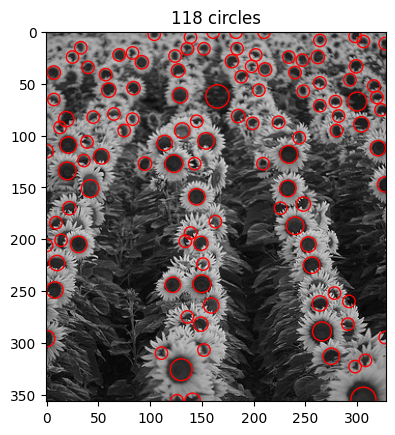

Execution time for downsampling approach: 0.2214 seconds


In [14]:
from skimage.transform import resize

# Parameters
sigma0 = 3
sigmaN = 8
scales = generate_sigma_space(sigma0, sigma_max=sigmaN, num_steps=15)

# Build the scale-space using downsampling
scale_space = np.zeros((x.shape[0], x.shape[1], len(scales)))
current_image = x.copy()

# Measure execution time for downsampling approach
start_time = time.time()

for i, sigma in enumerate(scales):
    downsample_factor = sigma / sigma0
    current_image = resize(x, (int(x.shape[0] / downsample_factor), int(x.shape[1] / downsample_factor)))
    log_filtered = gaussian_laplace(current_image, sigma=sigma)
    log_filtered = resize(log_filtered, x.shape)
    scale_space[:, :, i] = (sigma**2 * log_filtered)

# Detection in the scale-space
threshold = np.quantile(scale_space, 0.995)
thresholded = np.where(scale_space > threshold, scale_space, 0)

# Perform 2D non-maximum suppression at each scale
non_max_suppressed_2d = np.zeros_like(thresholded)
for i in range(len(scales)):
    max_filter_output = rank_filter(thresholded[:, :, i], rank=-1, size=3)
    non_max_suppressed_2d[:, :, i] = np.where(thresholded[:, :, i] == max_filter_output, thresholded[:, :, i], 0)

# Extend non-maximum suppression to 3D scale-space
max_filter_output_3d = rank_filter(non_max_suppressed_2d, rank=-1, size=(15, 15, len(scales)))
non_max_suppressed = np.where(non_max_suppressed_2d == max_filter_output_3d, non_max_suppressed_2d, 0)

# Measure execution time for downsampling approach
downsampling_time = time.time() - start_time

# Extract the coordinates of the centers and the radii of the detected blobs
cy, cx, cz = np.nonzero(non_max_suppressed)
radii = [scales[z] * 2 for z in cz]  # Radius is proportional to the scale

# Display the detected blobs on the original image
show_all_circles.show_all_circles(x, cx, cy, radii)
print(f"Execution time for downsampling approach: {downsampling_time:.4f} seconds")

## Exercise 4

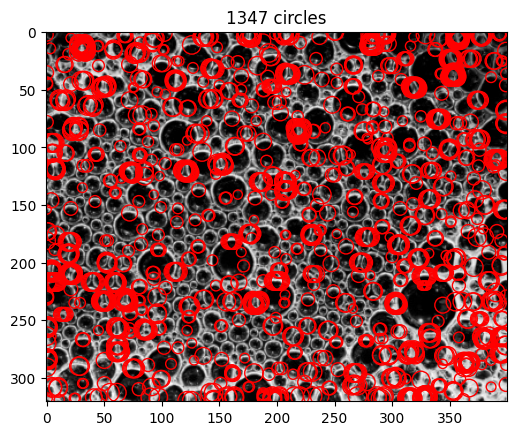

Execution time for filter width approach: 0.2148 seconds


In [24]:
# Load the water texture image
x = io.imread('./water_texture.jpg', as_gray=True)

sigma0 = 2
sigmaN = 4
scales = generate_sigma_space(sigma0, sigma_max=sigmaN, num_steps=15)

scale_space = np.zeros((x.shape[0], x.shape[1], len(scales)))

# Measure execution time for downsampling approach
start_time = time.time()

for i, sigma in enumerate(scales):
    log_filtered = gaussian_laplace(x, sigma=sigma)
    scale_space[:, :, i] = sigma**2 * log_filtered

# Perform non-maximum suppression at each scale
non_max_suppressed_2d = np.zeros_like(scale_space)
for i in range(len(scales)):
    # Apply thresholding to the filtered image
    threshold = np.quantile(scale_space[:, :, i], 0.99)
    thresholded = np.where(scale_space[:, :, i] > threshold, scale_space[:, :, i], 0)
    # Perform non-maximum suppression
    max_filter_output = rank_filter(thresholded, rank=-1, size=5)
    non_max_suppressed_2d[:, :, i] = np.where(thresholded == max_filter_output, thresholded, 0)

# Extend non-maximum suppression to 3D scale-space
max_filter_output_3d = rank_filter(non_max_suppressed_2d, rank=-1, size=(15, 15, len(scales)))
non_max_suppressed = np.where(non_max_suppressed_2d == max_filter_output_3d, non_max_suppressed_2d, 0)

# Measure execution time for downsampling approach
filter_time = time.time() - start_time

# Extract the coordinates of the centers and the radii of the detected blobs
cy, cx, cz = np.nonzero(non_max_suppressed)
radii = [scales[z]*2 for z in cz]  # Radius is proportional to the scale

show_all_circles.show_all_circles(x, cx, cy, radii)

print(f"Execution time for filter width approach: {filter_time:.4f} seconds")


1.0
2.0
2.0
1.0
2.0
2.0
1.0
2.0
2.0
1.0
2.0
2.0
1.0
2.0
2.0
1.0
2.0
2.0
1.0
2.0
2.0
1.0
2.0
2.0
1.0
2.0
2.0
1.0
2.0
2.0
1.0
2.0
2.0
1.0
2.0
2.0
1.0
2.0
2.0
1.0
2.0
2.0
1.0
2.0
2.0


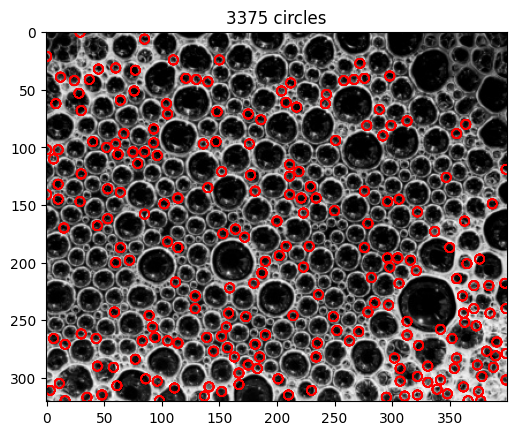

Execution time for downsampling approach: 0.2678 seconds


In [23]:
from skimage.transform import resize

# Parameters
sigma0 = 2
sigmaN = 2
scales = generate_sigma_space(sigma0, sigma_max=sigmaN, num_steps=15)

# Build the scale-space using downsampling
scale_space = np.zeros((x.shape[0], x.shape[1], len(scales)))
current_image = x.copy()

# Measure execution time for downsampling approach
start_time = time.time()

for i, sigma in enumerate(scales):
    downsample_factor = sigma / sigma0
    print(downsample_factor)
    print(sigma)
    print(sigma/downsample_factor)
    current_image = resize(x, (int(x.shape[0] / downsample_factor), int(x.shape[1] / downsample_factor)))
    log_filtered = gaussian_laplace(current_image, sigma=sigma)
    log_filtered = resize(log_filtered, x.shape)
    scale_space[:, :, i] = (sigma**2 * log_filtered)

# Detection in the scale-space
threshold = np.quantile(scale_space, 0.99)
thresholded = np.where(scale_space > threshold, scale_space, 0)

# Perform 2D non-maximum suppression at each scale
non_max_suppressed_2d = np.zeros_like(thresholded)
for i in range(len(scales)):
    max_filter_output = rank_filter(thresholded[:, :, i], rank=-1, size=3)
    non_max_suppressed_2d[:, :, i] = np.where(thresholded[:, :, i] == max_filter_output, thresholded[:, :, i], 0)

# Extend non-maximum suppression to 3D scale-space
max_filter_output_3d = rank_filter(non_max_suppressed_2d, rank=-1, size=(15, 15, len(scales)))
non_max_suppressed = np.where(non_max_suppressed_2d == max_filter_output_3d, non_max_suppressed_2d, 0)

# Measure execution time for downsampling approach
downsampling_time = time.time() - start_time

# Extract the coordinates of the centers and the radii of the detected blobs
cy, cx, cz = np.nonzero(non_max_suppressed)
radii = [scales[z] * 2 for z in cz]  # Radius is proportional to the scale

# Display the detected blobs on the original image
show_all_circles.show_all_circles(x, cx, cy, radii)
print(f"Execution time for downsampling approach: {downsampling_time:.4f} seconds")

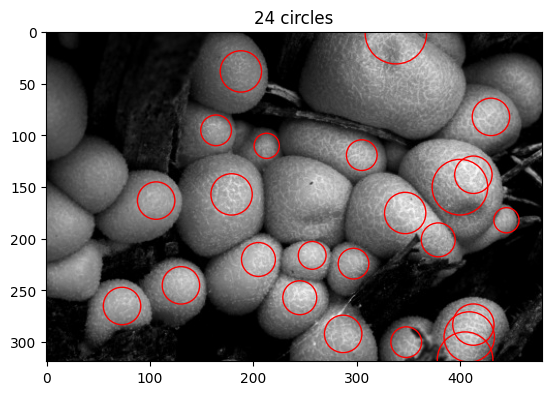

Execution time for downsampling approach: 0.3956 seconds


In [17]:
# Load the water texture image
x = io.imread('./fruits.jpg', as_gray=True)

# Parameters
sigma0 = 5
sigmaN = 20
threshold = 0.99
scales = generate_sigma_space(sigma0, sigma_max=sigmaN, num_steps=15)

# Build the scale-space using downsampling
scale_space = np.zeros((x.shape[0], x.shape[1], len(scales)))
current_image = x.copy()

# Measure execution time for downsampling approach
start_time = time.time()

for i, sigma in enumerate(scales):
    downsample_factor = sigma / sigma0
    current_image = resize(x, (int(x.shape[0] / downsample_factor), int(x.shape[1] / downsample_factor)))
    log_filtered = gaussian_laplace(current_image, sigma=sigma)
    log_filtered = resize(log_filtered, x.shape)
    scale_space[:, :, i] = (sigma**2 * log_filtered)

# Detection in the scale-space
scale_space = -scale_space
threshold = np.quantile(scale_space, threshold)
thresholded = np.where(scale_space > threshold, scale_space, 0)

# Perform 2D non-maximum suppression at each scale
non_max_suppressed_2d = np.zeros_like(thresholded)
for i in range(len(scales)):
    max_filter_output = rank_filter(thresholded[:, :, i], rank=-1, size=5)
    non_max_suppressed_2d[:, :, i] = np.where(thresholded[:, :, i] == max_filter_output, thresholded[:, :, i], 0)

# Extend non-maximum suppression to 3D scale-space
max_filter_output_3d = rank_filter(non_max_suppressed_2d, rank=-1, size=(15, 15, len(scales)))
non_max_suppressed = np.where(non_max_suppressed_2d == max_filter_output_3d, non_max_suppressed_2d, 0)

# Measure execution time for downsampling approach
downsampling_time = time.time() - start_time

# Extract the coordinates of the centers and the radii of the detected blobs
cy, cx, cz = np.nonzero(non_max_suppressed)
radii = [scales[z] * 2 for z in cz]  # Radius is proportional to the scale

# Display the detected blobs on the original image
show_all_circles.show_all_circles(x, cx, cy, radii)
print(f"Execution time for downsampling approach: {downsampling_time:.4f} seconds")
